In [1]:
!curl http://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip -o covid19.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62.8M  100 62.8M    0     0  4192k      0  0:00:15  0:00:15 --:--:-- 3923k


In [2]:
from pandas import read_csv, to_datetime

In [3]:
df = read_csv("covid19.zip", compression="zip", encoding="latin-1")
df["FECHA_ACTUALIZACION"] = to_datetime(df["FECHA_ACTUALIZACION"])
df["FECHA_INGRESO"] = to_datetime(df["FECHA_INGRESO"])
df["FECHA_SINTOMAS"] = to_datetime(df["FECHA_SINTOMAS"])
#df["FECHA_DEF"] = to_datetime(df["FECHA_DEF"])

In [4]:
index = df['CLASIFICACION_FINAL'] == 6
sospechosos = df[index].groupby(['ENTIDAD_UM', 'FECHA_INGRESO']).count()['ORIGEN']
index = df['CLASIFICACION_FINAL'].isin([1, 2, 3])
confirmados = df[index].groupby(['ENTIDAD_UM', 'FECHA_INGRESO']).count()['ORIGEN']
index = df['CLASIFICACION_FINAL'] == 7
negativos = df[index].groupby(['ENTIDAD_UM', 'FECHA_INGRESO']).count()['ORIGEN']

index = (df['CLASIFICACION_FINAL'].isin([1, 2, 3])) & (df['FECHA_DEF'] != '9999-99-99')
defunciones = df[index].groupby(['ENTIDAD_UM', 'FECHA_DEF']).count()['ORIGEN']

index = (df['CLASIFICACION_FINAL'].isin([1, 2, 3])) & (df['FECHA_DEF'] == '9999-99-99')
vivos = df[index].groupby(['ENTIDAD_UM', 'FECHA_DEF']).count()['ORIGEN']

index = (df['CLASIFICACION_FINAL'].isin([1, 2, 3]) & (df['TIPO_PACIENTE'] == 2))
hospitalizados = df[index].groupby(['ENTIDAD_UM', 'FECHA_INGRESO']).count()['ORIGEN']
index = (df['CLASIFICACION_FINAL'].isin([1, 2, 3]) & (df['UCI'] == 1))
cuidados_intensivos = df[index].groupby(['ENTIDAD_UM', 'FECHA_INGRESO']).count()['ORIGEN']
index = (df['CLASIFICACION_FINAL'].isin([1, 2, 3]) & (df['TIPO_PACIENTE'] == 1))
ambulatorios = df[index].groupby(['ENTIDAD_UM', 'FECHA_INGRESO']).count()['ORIGEN']

In [5]:
sospechosos_cdmx = sospechosos[9]
confirmados_cdmx = confirmados[9]
negativos_cdmx = negativos[9]
defunciones_cdmx = defunciones[9]
hospitalizados_cdmx = hospitalizados[9]
uci_cdmx = cuidados_intensivos[9]
ambulatorios_cdmx = ambulatorios[9]

In [6]:
acum_sospechosos_cdmx = sospechosos_cdmx.cumsum()
acum_confirmados_cdmx = confirmados_cdmx.cumsum()
acum_negativos_cdmx = negativos_cdmx.cumsum()
acum_defunciones_cdmx = defunciones_cdmx.cumsum()
acum_hospitalizados_cdmx = hospitalizados_cdmx.cumsum()
acum_uci_cdmx = uci_cdmx.cumsum()
acum_ambulatorios_cdmx = ambulatorios_cdmx.cumsum()

In [7]:
pruebas_cdmx = (confirmados_cdmx + negativos_cdmx).fillna(0)
positividad_cdmx = confirmados_cdmx/pruebas_cdmx

In [8]:
positividad_cdmx[0] = 0
positividad_cdmx = positividad_cdmx.fillna(method="ffill")

In [9]:
def filter(series, days=14):
    from pandas import Series
    from control import tf, forced_response
    G = tf([1], [days,1])
    xs = series.values
    x0 = xs[0]
    t1, y1, x1 = forced_response(G, T=range(len(xs)), U=xs, X0=0)
    return Series(data=y1, index=series.index)

In [10]:
fil_sospechosos_cdmx = filter(sospechosos_cdmx)
fil_confirmados_cdmx = filter(confirmados_cdmx)
fil_negativos_cdmx = filter(negativos_cdmx)
fil_positividad_cdmx = filter(positividad_cdmx)

In [11]:
from matplotlib.pyplot import figure, rcParams
from conf_matplotlib import conf_matplotlib_horizon
conf_matplotlib_horizon()

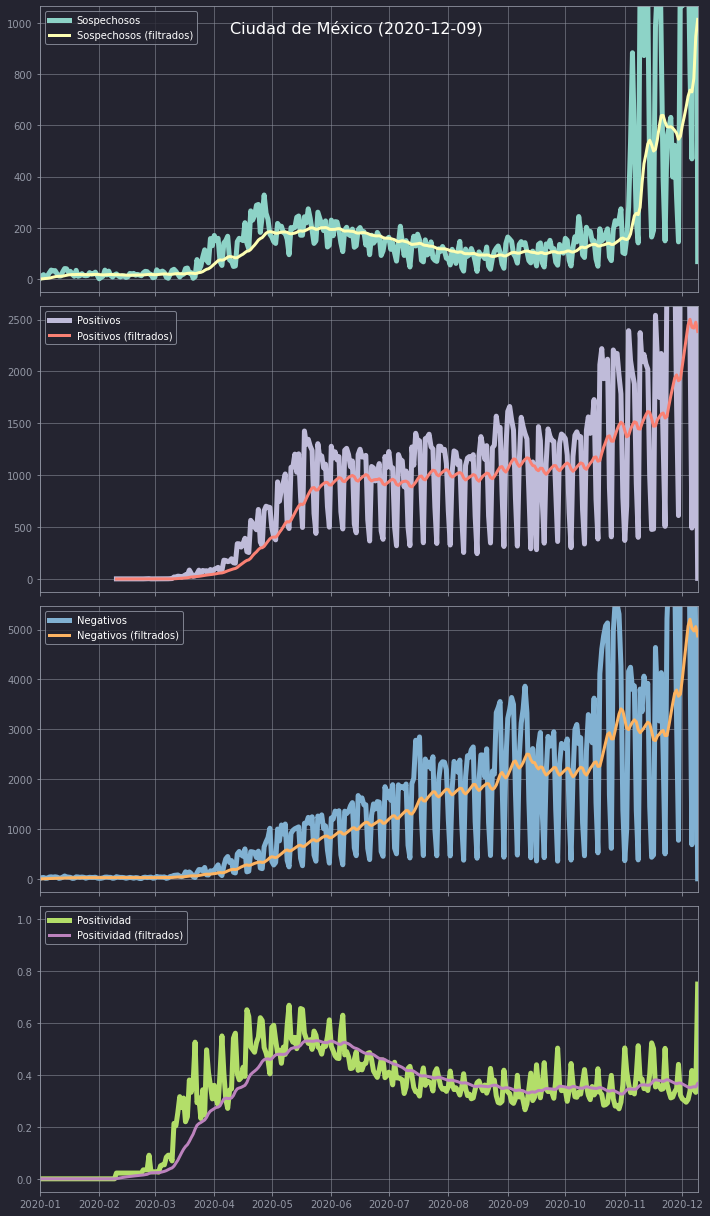

In [12]:
cycle = rcParams['axes.prop_cycle'].by_key()['color']

fig = figure(figsize=(10,17))
axs = fig.subplots(4, 1, gridspec_kw={'height_ratios': [2,2,2,2]}, sharex=True)
ax1, ax2, ax3, ax4 = axs

lbl_sos = f"Sospechosos"
lbl_pos = f"Positivos"
lbl_ptv = f"Positividad"
lbl_neg = f"Negativos"
lbl_cam = f"Tasa de cambio"
lbl_nue = f"Nuevos casos"
lbl_nue_fil = f"Nuevos casos (filtrados)"

ax1.plot(sospechosos_cdmx, label=lbl_sos, c=cycle[0])
ax1.plot(fil_sospechosos_cdmx, label=lbl_sos + " (filtrados)", c=cycle[1], lw=3)
ax2.plot(confirmados_cdmx, label=lbl_pos, c=cycle[2])
ax2.plot(fil_confirmados_cdmx, label=lbl_pos + " (filtrados)", c=cycle[3], lw=3)
ax3.plot(negativos_cdmx, label=lbl_neg, c=cycle[4])
ax3.plot(fil_negativos_cdmx, label=lbl_neg + " (filtrados)", c=cycle[5], lw=3)
ax4.plot(positividad_cdmx, label=lbl_ptv, c=cycle[6])
ax4.plot(fil_positividad_cdmx, label=lbl_ptv + " (filtrados)", c=cycle[7], lw=3)

ax1.set_ylim(-0.05*max(fil_sospechosos_cdmx),1.05*max(fil_sospechosos_cdmx))
ax2.set_ylim(-0.05*max(fil_confirmados_cdmx),1.05*max(fil_confirmados_cdmx))
ax3.set_ylim(-0.05*max(fil_negativos_cdmx),1.05*max(fil_negativos_cdmx))
ax4.set_ylim(-0.05,1.05)

ax4.set_xlim(sospechosos_cdmx.index[0], sospechosos_cdmx.index[-1])

ax1.legend(loc="upper left")
ax2.legend(loc="upper left")
ax3.legend(loc="upper left")
ax4.legend(loc="upper left")

#fig.legend(loc="upper left")
fig.tight_layout()
fig.suptitle("Ciudad de México (" + str(sospechosos_cdmx.index[-1].date()) + ")", fontsize=16);

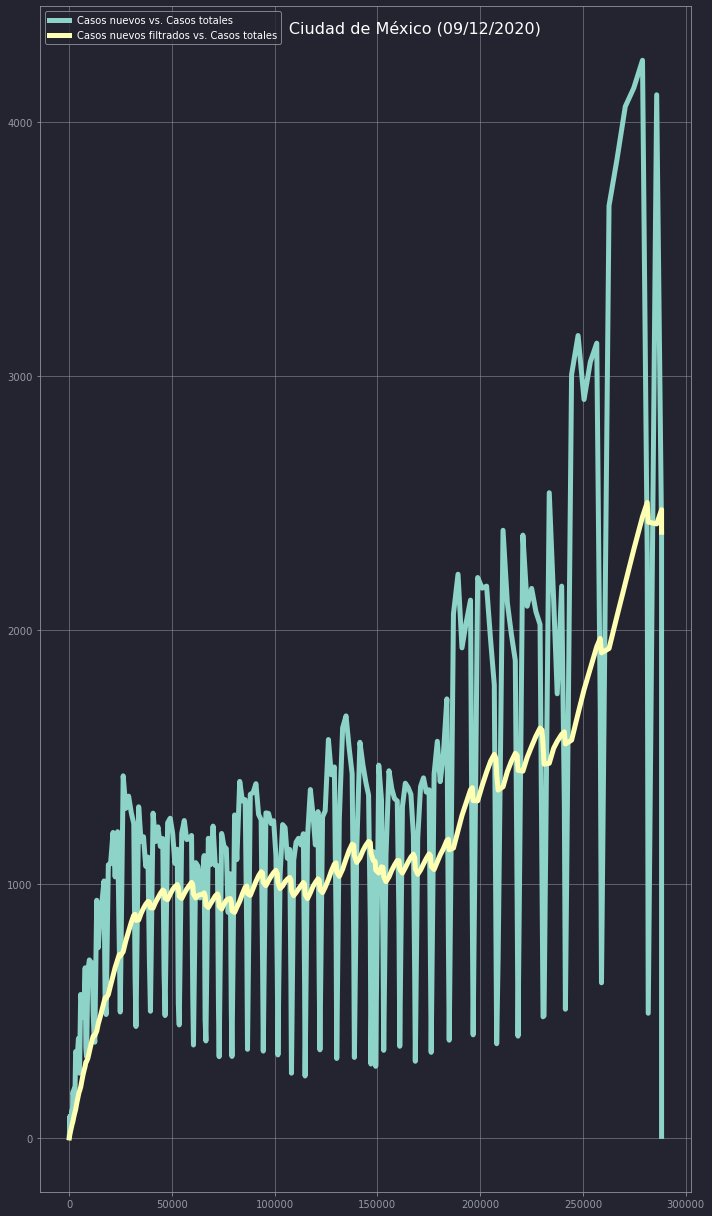

In [15]:
fig = figure(figsize=(10,17))
ax = fig.gca()

ax.plot(acum_confirmados_cdmx.values, confirmados_cdmx.values, label="Casos nuevos vs. Casos totales")
ax.plot(acum_confirmados_cdmx.values, fil_confirmados_cdmx.values, label="Casos nuevos filtrados vs. Casos totales")

#ax.set_xscale('log')
#ax.set_yscale('log')

ax.legend(loc="upper left")
fig.tight_layout()
fig.suptitle("                       Ciudad de México (" + confirmados_cdmx.index[-1].strftime("%d/%m/%Y") + ")", fontsize=16);